**Dataset Generation**

In [ ]:
# 📦 Step 1: Install dependencies (if needed)
!pip install -q pandas numpy

# 📦 Step 2: Import Libraries
import pandas as pd
import numpy as np
import random

# Reproducibility
np.random.seed(42)
random.seed(42)

# 🧠 Step 3: Basic Setup
n_samples = 5000
threat_classes = ['malware', 'phishing', 'insider', 'network', 'benign']
threat_class_probs = [0.25, 0.20, 0.20, 0.15, 0.20]  # includes benign now

# 🔧 Step 4: Generate Base Features
data = {
    'file_size_kb': np.random.exponential(scale=300, size=n_samples),
    'entropy': np.clip(np.random.normal(loc=6.5, scale=1.0, size=n_samples), 3, 9),
    'num_imported_symbols': np.random.poisson(lam=40, size=n_samples),
    'has_signature': np.random.binomial(1, 0.6, size=n_samples),
    'uses_network': np.random.binomial(1, 0.4, size=n_samples),
    'access_outside_hours': np.random.binomial(1, 0.3, size=n_samples),
    'url_length': np.random.randint(20, 150, size=n_samples),
    'domain_age_days': np.random.exponential(scale=365, size=n_samples),
    'num_suspicious_api_calls': np.random.poisson(lam=5, size=n_samples),
    'user_privilege_level': np.random.choice(['low', 'medium', 'high'], size=n_samples, p=[0.5, 0.3, 0.2]),
    'login_failures': np.random.poisson(lam=1, size=n_samples),
    'threat_type': np.random.choice(threat_classes, size=n_samples, p=threat_class_probs)
}

# 🔁 Step 5: Inject Real-World Patterns
df = pd.DataFrame(data)

# -- Malware patterns --
mask = df['threat_type'] == 'malware'
df.loc[mask, 'has_signature'] = np.random.binomial(1, 0.3, size=mask.sum())
df.loc[mask, 'num_suspicious_api_calls'] += np.random.randint(3, 10, size=mask.sum())

# -- Phishing patterns --
mask = df['threat_type'] == 'phishing'
df.loc[mask, 'url_length'] += np.random.randint(20, 100, size=mask.sum())
df.loc[mask, 'domain_age_days'] = np.random.exponential(scale=30, size=mask.sum())

# -- Insider patterns --
mask = df['threat_type'] == 'insider'
df.loc[mask, 'access_outside_hours'] = 1
df.loc[mask, 'login_failures'] += np.random.randint(1, 4, size=mask.sum())

# -- Network attack patterns --
mask = df['threat_type'] == 'network'
df.loc[mask, 'uses_network'] = 1
df.loc[mask, 'num_imported_symbols'] += np.random.randint(10, 30, size=mask.sum())

# ✅ -- NEW: Benign file patterns --
mask = df['threat_type'] == 'benign'
df.loc[mask, 'has_signature'] = 1
df.loc[mask, 'uses_network'] = 0
df.loc[mask, 'access_outside_hours'] = 0
df.loc[mask, 'domain_age_days'] = np.random.exponential(scale=500, size=mask.sum())
df.loc[mask, 'num_suspicious_api_calls'] = 0
df.loc[mask, 'login_failures'] = 0

# 🧼 Step 6: One-Hot Encode privilege level (same structure as before)
df_encoded = pd.get_dummies(df, columns=['user_privilege_level'], drop_first=True)

# 📊 Step 7: Preview (safe for visualizations / training)
df.head()


,file_size_kb,entropy,num_imported_symbols,has_signature,uses_network,access_outside_hours,url_length,domain_age_days,num_suspicious_api_calls,user_privilege_level,login_failures,threat_type
0,140.780427,5.903026,35,1,1,1,86,18.229351,6,low,1,insider
1,903.036429,4.109696,79,1,1,0,30,127.325471,5,medium,1,network
2,395.023708,6.087779,39,0,0,1,115,377.260400,8,low,4,insider
3,273.882766,7.413474,47,1,1,0,135,63.757178,10,medium,1,phishing
4,50.887461,7.037630,47,1,0,0,105,95.418806,0,medium,0,benign


In [ ]:
# List of your classes
threat_classes = ['malware', 'phishing', 'insider', 'network', 'benign']

# Create a dict mapping class→subset
class_dfs = {
    cls: df[df['threat_type'] == cls].copy()
    for cls in threat_classes
}

# Example: inspect the first few phishing samples
print(class_dfs['phishing'].head())


    file_size_kb   entropy  num_imported_symbols  has_signature  uses_network  \
3     273.882766  7.413474                    47              1             1   
10      6.239792  8.684097                    38              1             0   
15     60.783427  6.260498                    45              0             0   
18    169.661120  5.768368                    35              1             0   
42     10.498116  6.742882                    44              0             0   

    access_outside_hours  url_length  domain_age_days  \
3                      0         135        63.757178   
10                     0         198        46.167969   
15                     1         183        50.997016   
18                     0         102        13.021731   
42                     0         101         1.783210   

    num_suspicious_api_calls user_privilege_level  login_failures threat_type  
3                         10               medium               1    phishing  
10        

In [ ]:
# Define your ordered categories (optional – order only matters if you care which label gets which number)
cats = ['malware','phishing','insider','network','benign']

# Convert to a categorical dtype with a known order
df['threat_label'] = pd.Categorical(df['threat_type'], categories=cats).codes

# Inspect your mapping
mapping = dict(enumerate(pd.Categorical(cats, categories=cats).categories))
print("Class → label name:", mapping)
print(df[['threat_type','threat_label']].head())


Class → label name: {0: 'malware', 1: 'phishing', 2: 'insider', 3: 'network', 4: 'benign'}
  threat_type  threat_label
0     insider             2
1     network             3
2     insider             2
3    phishing             1
4      benign             4


In [ ]:
df['threat_type'].value_counts()


,count
threat_type,
malware,1234
insider,1042
benign,1005
phishing,999
network,720


**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder instance
le = LabelEncoder()

# Fit and transform the 'threat_type' column
df_encoded['threat_type_encoded'] = le.fit_transform(df_encoded['threat_type'])

# View how the encoding mapped threat types to numbers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Map:", label_mapping)

# Optional: Drop original 'threat_type' if you only want the encoded one
# df_encoded.drop(columns=['threat_type'], inplace=True)


Label Encoding Map: {'benign': np.int64(0), 'insider': np.int64(1), 'malware': np.int64(2), 'network': np.int64(3), 'phishing': np.int64(4)}


**Log Transform skewed columns**

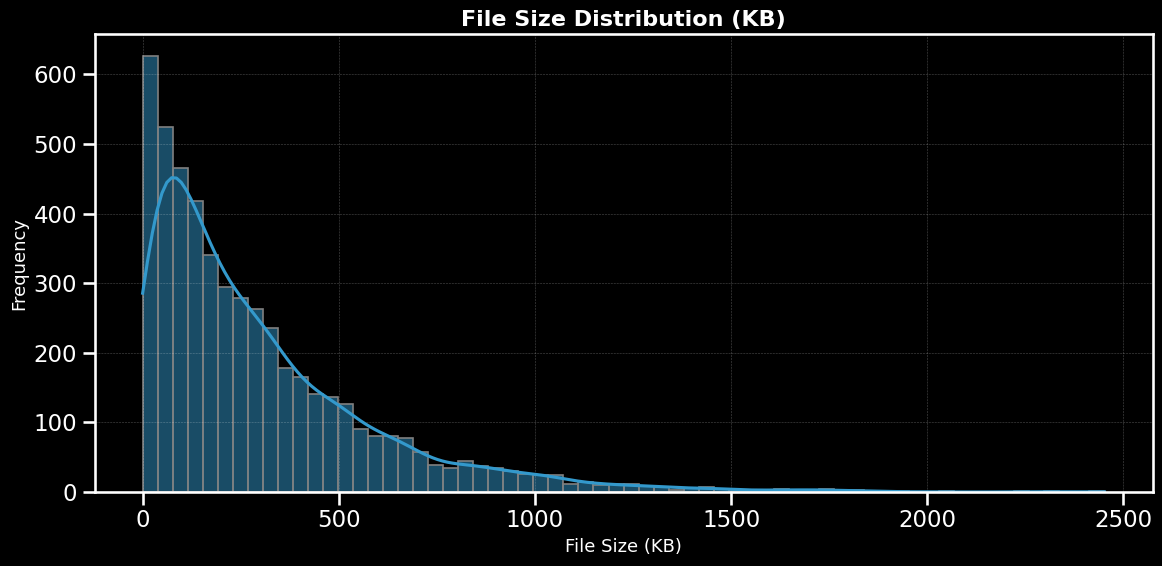

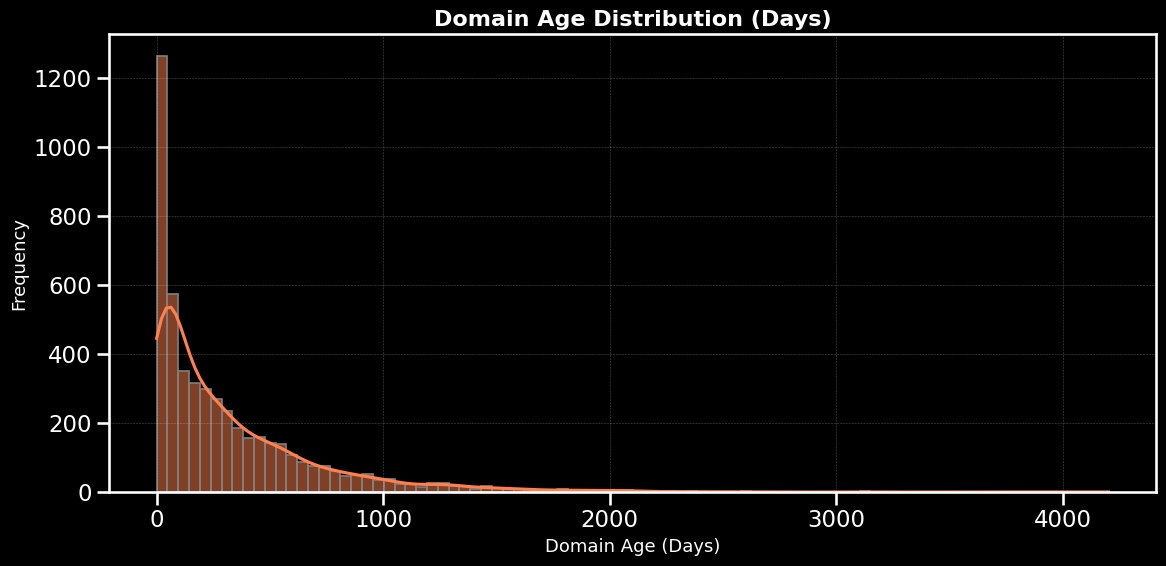

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply dark background
plt.style.use("dark_background")
sns.set_context("talk")

# Updated, muted professional color palette
file_color = (0.2, 0.6, 0.8, 0.7)     # Transparent teal-blue
domain_color = (1.0, 0.5, 0.3, 0.7)   # Transparent orange

# Histogram for File Size
plt.figure(figsize=(12, 6))
sns.histplot(df_encoded['file_size_kb'], kde=True,
             color=file_color, edgecolor='gray', linewidth=1.2)
plt.title("File Size Distribution (KB)", fontsize=16, fontweight='bold')
plt.xlabel("File Size (KB)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.grid(visible=True, linestyle='--', linewidth=0.4, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram for Domain Age
plt.figure(figsize=(12, 6))
sns.histplot(df_encoded['domain_age_days'], kde=True,
             color=domain_color, edgecolor='gray', linewidth=1.2)
plt.title("Domain Age Distribution (Days)", fontsize=16, fontweight='bold')
plt.xlabel("Domain Age (Days)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.grid(visible=True, linestyle='--', linewidth=0.4, alpha=0.3)
plt.tight_layout()
plt.show()




**Data Visualisation**

In [ ]:
!pip install plotly


**Threat Type Class Distribution**

In [ ]:
import plotly.express as px

# Count threat types
threat_counts = df_encoded['threat_type'].value_counts().reset_index()
threat_counts.columns = ['Threat Type', 'Count']

fig = px.pie(threat_counts,
             values='Count',
             names='Threat Type',
             hole=0.5,
             title=' Threat Class Distribution',
             color_discrete_sequence=px.colors.sequential.Plasma_r)

fig.update_layout(
    template='plotly_dark',
    title_font_size=22,
    title_font_family='Arial Black',
    font=dict(color='white'),
    legend=dict(title='Threat Type')
)
fig.show()


**Correlation heatmap**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for threat in df_encoded['threat_type'].unique():
    fig.add_trace(go.Violin(
        x=df_encoded['threat_type'][df_encoded['threat_type'] == threat],
        y=df_encoded['entropy'][df_encoded['threat_type'] == threat],
        name=threat,
        box_visible=True,
        meanline_visible=True
    ))

fig.update_layout(
    title="Entropy Distribution by Threat Type",
    template="plotly_dark",
    violingap=0.4,
    font=dict(color='white'),
    title_font_size=22
)
fig.show()



**Distribution of Key Feature**

In [ ]:
# Average values for each class
radar_df = df_encoded.groupby('threat_type')[
    ['file_size_kb', 'entropy', 'domain_age_days', 'num_suspicious_api_calls']
].mean().reset_index()

# Normalize values for radar
radar_scaled = (radar_df.drop(columns='threat_type') - radar_df.drop(columns='threat_type').min()) / \
               (radar_df.drop(columns='threat_type').max() - radar_df.drop(columns='threat_type').min())

radar_scaled['threat_type'] = radar_df['threat_type']

# Plot radar chart
fig = go.Figure()

for _, row in radar_scaled.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[:-1].values,
        theta=radar_scaled.columns[:-1],
        fill='toself',
        name=row['threat_type']
    ))

fig.update_layout(
    title="Threat Class Feature Profiles (Radar Chart)",
    template='plotly_dark',
    polar=dict(
        radialaxis=dict(visible=True)
    ),
    font=dict(color='white'),
    title_font_size=20
)
fig.show()



**Feature Comparison across Threat Types**

In [ ]:
import plotly.express as px
import pandas as pd

# Choose the features to compare
features_to_plot = ['file_size_kb', 'entropy', 'domain_age_days', 'num_suspicious_api_calls', 'login_failures']

# Compute mean values grouped by threat type
mean_df = df_encoded.groupby('threat_type')[features_to_plot].mean().reset_index()

# Melt into long format
melted_df = pd.melt(mean_df, id_vars='threat_type', var_name='Feature', value_name='Average Value')

# Use a cool, elegant color palette (Cividis or Tealgrn)
fig = px.bar(
    melted_df,
    x='Feature',
    y='Average Value',
    color='threat_type',
    barmode='group',
    template='plotly_dark',
    title='Average Feature Values by Threat Type',
    color_discrete_sequence=px.colors.sequential.Cividis
)

# Layout cleanup for professional look
fig.update_layout(
    font=dict(family='Segoe UI', color='white', size=14),
    title_font=dict(size=22, family='Segoe UI Bold'),
    xaxis_title='Feature',
    yaxis_title='Average Value',
    legend_title='Threat Type',
    bargap=0.25,
    plot_bgcolor='#111111',
    paper_bgcolor='#111111'
)

fig.show()



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create and fit encoder
label_encoder = LabelEncoder()
df_encoded['threat_type'] = label_encoder.fit_transform(df_encoded['threat_type'])

# Now continue with train-test split
X = df_encoded.drop('threat_type', axis=1)
y = df_encoded['threat_type']


**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Define feature set and target variable
X = df_encoded.drop(columns=['threat_type', 'threat_type_encoded'])  # drop both if encoded version exists
y = df_encoded['threat_type_encoded']  # use label encoded target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance same in train/test
)

# Check shapes
print("Training Set:", X_train.shape)
print("Test Set:", X_test.shape)


Training Set: (4000, 12)
Test Set: (1000, 12)


In [ ]:
import pandas as pd

# Assuming y_train and y_test contain class labels
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Get consistent class labels (index)
classes = train_counts.index.tolist()


In [ ]:
import plotly.graph_objects as go

# Transparent and elegant color palette
train_color = 'rgba(255, 99, 132, 0.6)'   # Soft pink, semi-transparent
test_color = 'rgba(54, 162, 235, 0.6)'    # Soft blue, semi-transparent
border_color = 'rgba(255,255,255,0.8)'    # Light white borders

background = '#0f1117'  # Dashboard-style dark background

fig = go.Figure()

# Bar for Train
fig.add_trace(go.Bar(
    x=classes,
    y=train_counts.values,
    name='Train Set',
    marker=dict(
        color=train_color,
        line=dict(color=border_color, width=1.5)
    )
))

# Bar for Test
fig.add_trace(go.Bar(
    x=classes,
    y=test_counts.values,
    name='Test Set',
    marker=dict(
        color=test_color,
        line=dict(color=border_color, width=1.5)
    )
))

# Layout updates
fig.update_layout(
    title='Train vs Test Split by Threat Class',
    xaxis_title='Threat Class',
    yaxis_title='Number of Samples',
    font=dict(color='white', family='Segoe UI', size=14),
    barmode='group',
    paper_bgcolor=background,
    plot_bgcolor=background,
    legend=dict(
        bgcolor='rgba(0,0,0,0)',
        borderwidth=0,
        font=dict(color='white')
    ),
    xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='rgba(255,255,255,0.05)'),
    bargap=0.25
)

fig.show()





Accuracy: 0.922

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       0.88      0.91      0.90       208
           2       0.92      0.92      0.92       247
           3       0.93      0.88      0.90       144
           4       0.89      0.89      0.89       200

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000


Confusion Matrix:
 [[201   0   0   0   0]
 [  0 189   6   2  11]
 [  0  10 228   4   5]
 [  0   5   5 127   7]
 [  0  10   9   4 177]]


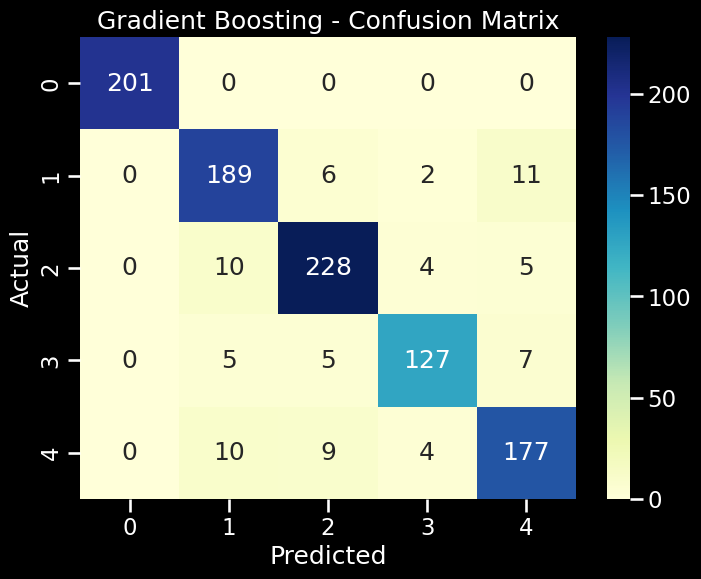

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train the Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# 2. Predict on Test Set
y_pred = gb_model.predict(X_test)

# 3. Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 4. Plot Confusion Matrix (optional but nice)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu', xticklabels=gb_model.classes_, yticklabels=gb_model.classes_)
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Train the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=150,       # Number of trees in the forest
    max_depth=12,           # Prevent overfitting
    random_state=42,        # For reproducibility
    class_weight='balanced' # Handles imbalanced threat classes
)

# Train the model
rf_model.fit(X_train, y_train)

# Confirm training complete
print("✅ Model trained successfully.")


✅ Model trained successfully.


**Testing the Model

In [ ]:
# Predict the threat class for the test set
y_pred = rf_model.predict(X_test)

# (Optional) Predict probabilities if you want confidence scores later
y_proba = rf_model.predict_proba(X_test)

# Check first 10 predictions
print(" Sample Predictions:", y_pred[:10])
# Convert encoded predictions back to original class names
decoded_predictions = label_encoder.inverse_transform(y_pred[:10])
print(" Decoded Predictions:", decoded_predictions)



 Sample Predictions: [2 2 4 3 4 2 1 3 0 4]
 Decoded Predictions: ['malware' 'malware' 'phishing' 'network' 'phishing' 'malware' 'insider'
 'network' 'benign' 'phishing']


**Model Accuracy and Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f" Accuracy: {accuracy:.4f}")


 Accuracy: 0.9260


In [ ]:
from sklearn.metrics import classification_report

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


 Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       201
     insider       0.89      0.91      0.90       208
     malware       0.92      0.93      0.92       247
     network       0.95      0.90      0.93       144
    phishing       0.89      0.89      0.89       200

    accuracy                           0.93      1000
   macro avg       0.93      0.92      0.93      1000
weighted avg       0.93      0.93      0.93      1000



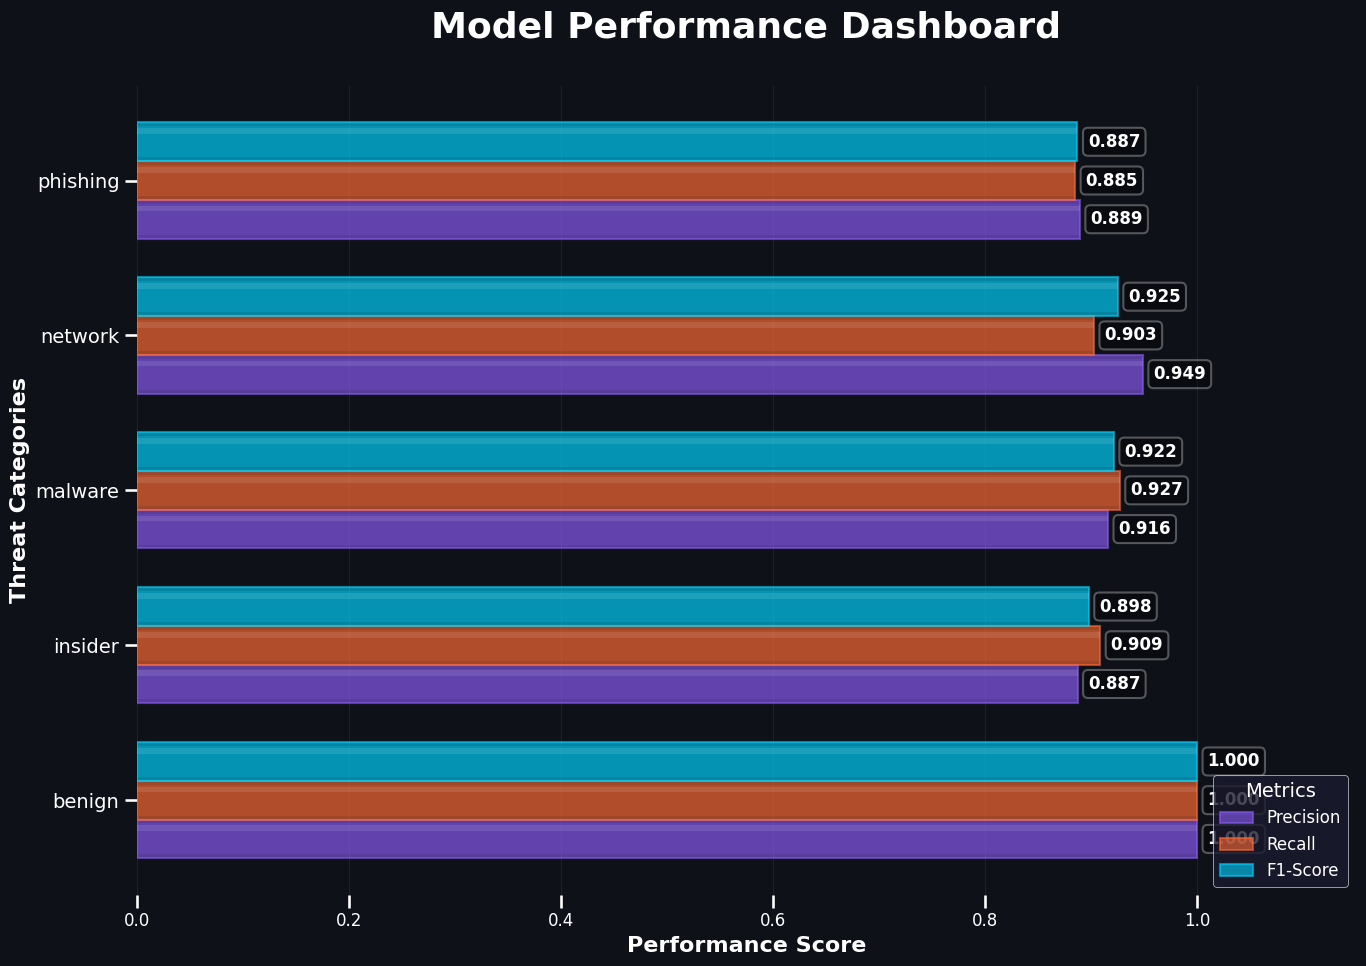

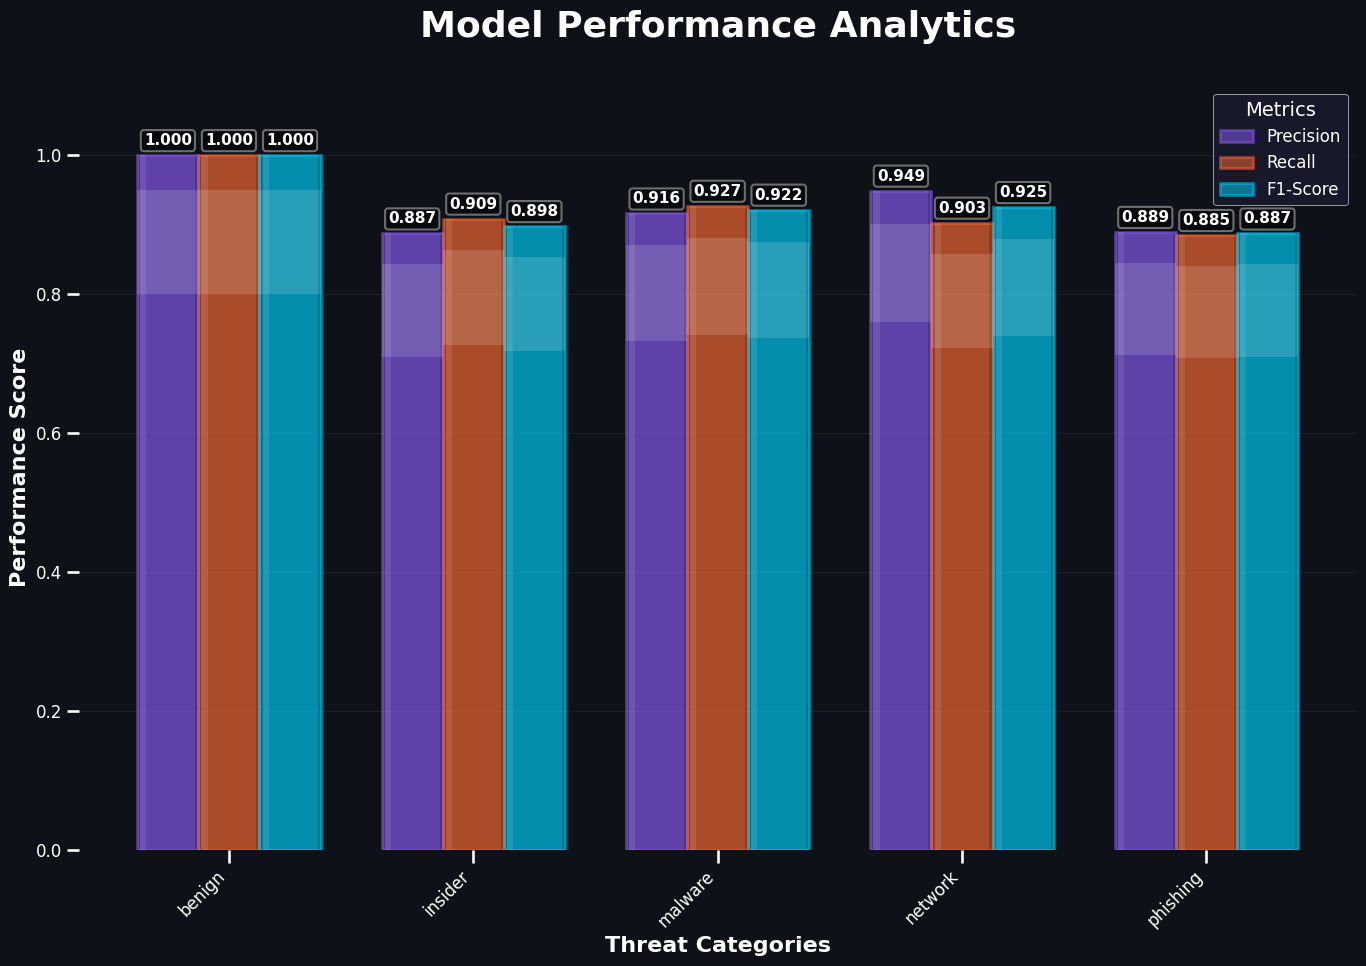

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Set the style for dark theme
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#0e1117'
plt.rcParams['axes.facecolor'] = '#0e1117'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# ---------------------------
# Generate Classification Report as DataFrame
# ---------------------------
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().reset_index()

# Only keep actual class rows (not avg/accuracy)
class_metrics_df = report_df[report_df['index'].isin(label_encoder.classes_)]

# ---------------------------
# Create Professional Transparent Horizontal Bars
# ---------------------------
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#0e1117')
ax.set_facecolor('#0e1117')

# Vibrant colors for transparency
colors = {
    'precision': '#8B5CF6',  # Purple
    'recall': '#FF6B35',     # Orange
    'f1-score': '#00D2FF'    # Cyan
}

# Get data
classes = class_metrics_df['index'].values
precision_scores = class_metrics_df['precision'].values
recall_scores = class_metrics_df['recall'].values
f1_scores = class_metrics_df['f1-score'].values

# Create positions for bars
y_positions = np.arange(len(classes))
bar_height = 0.25

# Create transparent horizontal bars
bars1 = ax.barh(y_positions - bar_height, precision_scores, bar_height,
                color=colors['precision'], alpha=0.6, label='Precision',
                edgecolor=colors['precision'], linewidth=1.5)

bars2 = ax.barh(y_positions, recall_scores, bar_height,
                color=colors['recall'], alpha=0.6, label='Recall',
                edgecolor=colors['recall'], linewidth=1.5)

bars3 = ax.barh(y_positions + bar_height, f1_scores, bar_height,
                color=colors['f1-score'], alpha=0.6, label='F1-Score',
                edgecolor=colors['f1-score'], linewidth=1.5)

# Add glassmorphism effect with additional transparent layers
for bars, color in zip([bars1, bars2, bars3], colors.values()):
    for bar in bars:
        # Add inner glow effect
        x = bar.get_x()
        y = bar.get_y()
        width = bar.get_width()
        height = bar.get_height()

        # Create inner transparent layer
        inner_bar = plt.Rectangle((x, y + height*0.1), width, height*0.8,
                                facecolor=color, alpha=0.2, edgecolor='none')
        ax.add_patch(inner_bar)

        # Create highlight on top
        highlight = plt.Rectangle((x, y + height*0.7), width, height*0.15,
                                facecolor='white', alpha=0.1, edgecolor='none')
        ax.add_patch(highlight)

# Add value labels with glow effect
for i, (bars, scores) in enumerate(zip([bars1, bars2, bars3],
                                     [precision_scores, recall_scores, f1_scores])):
    for j, (bar, score) in enumerate(zip(bars, scores)):
        # Add shadow/glow effect to text
        ax.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}',
                ha='left', va='center',
                fontsize=12, color='white', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.3))

# Customize the plot
ax.set_title('Model Performance Dashboard', fontsize=26, fontweight='bold',
             color='white', pad=35)

# Set labels and ticks
ax.set_ylabel('Threat Categories', fontsize=16, fontweight='600', color='white')
ax.set_xlabel('Performance Score', fontsize=16, fontweight='600', color='white')

ax.set_yticks(y_positions)
ax.set_yticklabels(classes, fontsize=14, color='white')

# Set x-axis
ax.set_xlim(0, 1.15)
ax.set_xticks(np.arange(0, 1.2, 0.2))
ax.set_xticklabels([f'{x:.1f}' for x in np.arange(0, 1.2, 0.2)],
                   fontsize=12, color='white')

# Add subtle grid lines
ax.grid(True, linestyle='-', alpha=0.1, color='white', axis='x', linewidth=0.5)
ax.set_axisbelow(True)

# Create transparent legend
legend = ax.legend(loc='lower right', frameon=True, fontsize=12,
                  title='Metrics', title_fontsize=14)
legend.get_frame().set_facecolor('#1a1a2e')
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_linewidth(0.5)

# Remove all spines for clean look
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# ---------------------------
# Alternative: Vertical Transparent Bars (More Glassmorphism)
# ---------------------------
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#0e1117')
ax.set_facecolor('#0e1117')

# Create vertical transparent bars
x_positions = np.arange(len(classes))
bar_width = 0.25

# Create transparent vertical bars with stronger glass effect
bars1 = ax.bar(x_positions - bar_width, precision_scores, bar_width,
               color=colors['precision'], alpha=0.5, label='Precision',
               edgecolor=colors['precision'], linewidth=2)

bars2 = ax.bar(x_positions, recall_scores, bar_width,
               color=colors['recall'], alpha=0.5, label='Recall',
               edgecolor=colors['recall'], linewidth=2)

bars3 = ax.bar(x_positions + bar_width, f1_scores, bar_width,
               color=colors['f1-score'], alpha=0.5, label='F1-Score',
               edgecolor=colors['f1-score'], linewidth=2)

# Add multiple transparent layers for glassmorphism
for bars, color in zip([bars1, bars2, bars3], colors.values()):
    for bar in bars:
        x = bar.get_x()
        y = bar.get_y()
        width = bar.get_width()
        height = bar.get_height()

        # Layer 1: Inner glow
        inner_bar = plt.Rectangle((x + width*0.05, y), width*0.9, height,
                                facecolor=color, alpha=0.3, edgecolor='none')
        ax.add_patch(inner_bar)

        # Layer 2: Top highlight
        highlight = plt.Rectangle((x, y + height*0.8), width, height*0.15,
                                facecolor='white', alpha=0.15, edgecolor='none')
        ax.add_patch(highlight)

        # Layer 3: Side reflection
        reflection = plt.Rectangle((x + width*0.05, y), width*0.1, height,
                                 facecolor='white', alpha=0.1, edgecolor='none')
        ax.add_patch(reflection)

# Add value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=11, color='white', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.4))

# Customize
ax.set_title('Model Performance Analytics', fontsize=26, fontweight='bold',
             color='white', pad=35)

ax.set_xlabel('Threat Categories', fontsize=16, fontweight='600', color='white')
ax.set_ylabel('Performance Score', fontsize=16, fontweight='600', color='white')

ax.set_xticks(x_positions)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=12, color='white')

ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticklabels([f'{x:.1f}' for x in np.arange(0, 1.2, 0.2)],
                   fontsize=12, color='white')

# Grid and legend
ax.grid(True, linestyle='-', alpha=0.1, color='white', axis='y', linewidth=0.5)
ax.set_axisbelow(True)

legend = ax.legend(loc='upper right', frameon=True, fontsize=12,
                  title='Metrics', title_fontsize=14)
legend.get_frame().set_facecolor('#1a1a2e')
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_linewidth(0.5)

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------
# Plotly Version for Better Transparency Effects
# ---------------------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot
fig = make_subplots(rows=1, cols=1)

# Add transparent bars
fig.add_trace(go.Bar(
    y=classes,
    x=precision_scores,
    name='Precision',
    marker_color='rgba(139, 92, 246, 0.6)',  # Purple with transparency
    marker_line_color='rgba(139, 92, 246, 1)',
    marker_line_width=2,
    orientation='h',
    text=[f'{score:.3f}' for score in precision_scores],
    textposition='outside',
    textfont=dict(color='white', size=12)
))

fig.add_trace(go.Bar(
    y=classes,
    x=recall_scores,
    name='Recall',
    marker_color='rgba(255, 107, 53, 0.6)',  # Orange with transparency
    marker_line_color='rgba(255, 107, 53, 1)',
    marker_line_width=2,
    orientation='h',
    text=[f'{score:.3f}' for score in recall_scores],
    textposition='outside',
    textfont=dict(color='white', size=12)
))

fig.add_trace(go.Bar(
    y=classes,
    x=f1_scores,
    name='F1-Score',
    marker_color='rgba(0, 210, 255, 0.6)',  # Cyan with transparency
    marker_line_color='rgba(0, 210, 255, 1)',
    marker_line_width=2,
    orientation='h',
    text=[f'{score:.3f}' for score in f1_scores],
    textposition='outside',
    textfont=dict(color='white', size=12)
))

# Update layout
fig.update_layout(
    title=dict(
        text='Model Performance Dashboard',
        x=0.5,
        font=dict(size=24, color='white')
    ),
    xaxis=dict(
        title='Performance Score',
        titlefont=dict(size=16, color='white'),
        tickfont=dict(size=12, color='white'),
        gridcolor='rgba(255, 255, 255, 0.1)',
        range=[0, 1.1]
    ),
    yaxis=dict(
        title='Threat Categories',
        titlefont=dict(size=16, color='white'),
        tickfont=dict(size=12, color='white')
    ),
    plot_bgcolor='#0e1117',
    paper_bgcolor='#0e1117',
    font=dict(color='white'),
    legend=dict(
        bgcolor='rgba(26, 26, 46, 0.8)',
        bordercolor='white',
        borderwidth=1,
        font=dict(color='white')
    ),
    barmode='group',
    height=600
)

fig.show()

/tmp/ipython-input-22-644776360.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-22-644776360.py:37: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



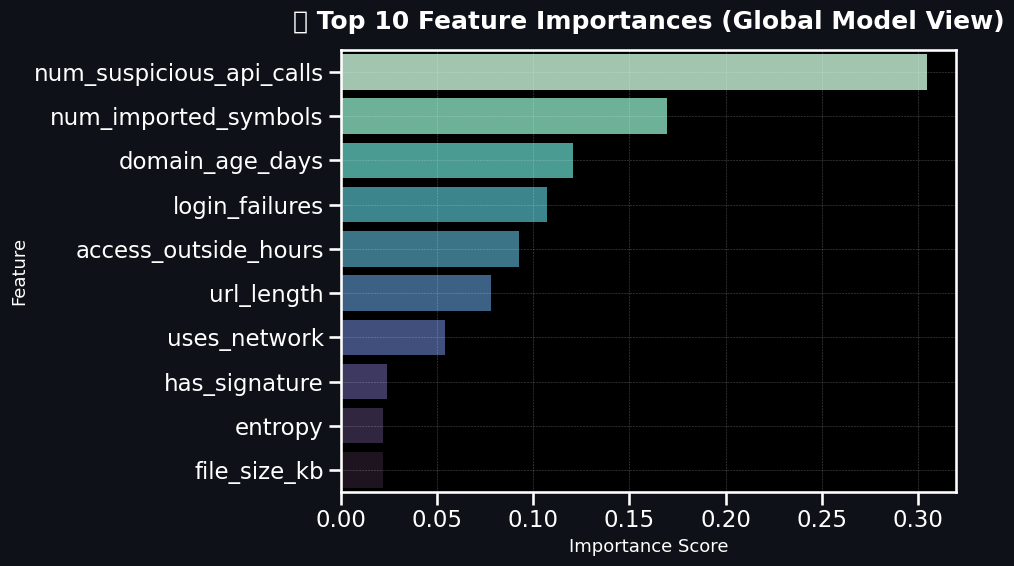

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for sorting + plotting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Take Top 10 Most Important Features
top_feat_df = feat_df.head(10)

# ----------------------------
# Plot: Soft Professional Style
# ----------------------------
plt.figure(figsize=(10, 6))
plt.style.use("dark_background")
sns.set_context("talk")

# Barplot with soft neon-transparent style
bar_colors = sns.color_palette("mako_r", n_colors=10)
sns.barplot(data=top_feat_df, x='Importance', y='Feature', palette=bar_colors, alpha=0.9)

# Labels & Title
plt.title("🔥 Top 10 Feature Importances (Global Model View)", fontsize=18, weight='bold', color='white', pad=15)
plt.xlabel("Importance Score", fontsize=13, color='white')
plt.ylabel("Feature", fontsize=13, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.3)
plt.tight_layout()
plt.show()


**XAI**


In [ ]:
pip install shap


In [ ]:
import shap
import numpy as np

# Explainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Take a sample to explain
sample_idx = 10
sample_input = X_test.iloc[[sample_idx]]

# Compute SHAP values
shap_values = explainer.shap_values(sample_input)


In [ ]:
import shap
import numpy as np
import pandas as pd

# Feature descriptions dictionary — customize this as needed
feature_desc = {
    'file_size_kb': "File size in kilobytes. Larger files may contain more complex code or hidden payloads.",
    'entropy': "Entropy measures randomness in file content. Higher entropy can indicate obfuscation.",
    'num_imported_symbols': "Number of imported functions. High count might mean complex behavior.",
    'has_signature': "Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.",
    'uses_network': "Whether the file attempts network access, a common trait in malware.",
    'access_outside_hours': "Activity outside normal hours can signal malicious behavior.",
    'url_length': "Length of URL associated with file. Very long URLs can be suspicious.",
    'domain_age_days': "Age of domain in days. New domains are often risky.",
    'num_suspicious_api_calls': "Count of suspicious API calls made by the file.",
    'login_failures': "Number of failed login attempts.",
    'user_privilege_level_low': "Indicates low privilege user.",
    'user_privilege_level_medium': "Indicates medium privilege user."
}

# Optional: Flatten or convert columns to strings if needed
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['_'.join(map(str, col)) for col in X_test.columns.values]
else:
    X_test.columns = [col if isinstance(col, str) else str(col) for col in X_test.columns]

# -------------------------------
# Prepare SHAP Explainer
# -------------------------------
explainer = shap.TreeExplainer(rf_model)

# Choose a sample index to explain
sample_idx = 10
sample_input = X_test.iloc[[sample_idx]]

# Predict the class
predicted_class_index = rf_model.predict(sample_input)[0]
class_name = label_encoder.inverse_transform([predicted_class_index])[0]

# Compute SHAP values
shap_values = explainer.shap_values(sample_input)

print(f"\n🧠 Predicted Threat Type: {class_name}\n")

# -------------------------------
# 1️⃣ Explanation for Tech Users with Text
# -------------------------------
print("1️⃣ Explanation for Tech Users:")
print("→ SHAP value breakdown (feature contributions with explanations):")

if isinstance(shap_values, list):
    relevant_shap = shap_values[predicted_class_index][0]
else:
    relevant_shap = shap_values[0]

sorted_indices = np.argsort(-np.abs(relevant_shap))

for i in sorted_indices[:5]:
    feat = X_test.columns[i]

    # Ensure feat is a string key, not Index or tuple
    if isinstance(feat, (pd.Index, list, tuple)):
        feat = feat[0]

    val = sample_input.iloc[0][feat]

    shap_score_raw = relevant_shap[i]
    arr = np.array(shap_score_raw)

    if arr.size == 1:
        shap_score = arr.item()
    else:
        shap_score = arr.mean()
    shap_score = float(shap_score)

    if hasattr(val, "__len__") and not isinstance(val, str):
        val_array = np.array(val)
        if val_array.size == 1:
            val = val_array.item()

    explanation = feature_desc.get(feat, "No description available.")

    print(f"   • {feat} (value = {val}) ➜ SHAP = {shap_score:+.3f}")
    print(f"     Explanation: {explanation}\n")

# -------------------------------
# 2️⃣ Explanation for Non-Tech Users
# -------------------------------
print("\n2️⃣ Explanation for Non-Tech Users:")
non_tech = []

if 'file_size_kb' in X_test.columns and sample_input['file_size_kb'].values[0] > 7000:
    non_tech.append("It is a very large file")
if 'entropy' in X_test.columns and sample_input['entropy'].values[0] > 7.5:
    non_tech.append("It has a complex internal structure, often used to hide malware")
if 'domain_age_days' in X_test.columns and sample_input['domain_age_days'].values[0] < 10:
    non_tech.append("It comes from a newly created or suspicious website")
if 'num_suspicious_api_calls' in X_test.columns and sample_input['num_suspicious_api_calls'].values[0] > 15:
    non_tech.append("It uses many dangerous functions common in malicious software")

if non_tech:
    print("→ This sample raised red flags because:")
    for reason in non_tech:
        print(f"   • {reason}")
else:
    print("→ The model found subtle risk signals even though no single feature stood out.")




🧠 Predicted Threat Type: insider

1️⃣ Explanation for Tech Users:
→ SHAP value breakdown (feature contributions with explanations):
   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.

   • num_imported_symbols (value = 47) ➜ SHAP = +0.000
     Explanation: Number of imported functions. High count might mean complex behavior.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.


2️⃣ Explanation for Non-Tech Users:
→ This sample raised red f

In [ ]:
import shap
import numpy as np
import pandas as pd

# Feature descriptions dictionary — customize this as needed
feature_desc = {
    'file_size_kb': "File size in kilobytes. Larger files may contain more complex code or hidden payloads.",
    'entropy': "Entropy measures randomness in file content. Higher entropy can indicate obfuscation.",
    'num_imported_symbols': "Number of imported functions. High count might mean complex behavior.",
    'has_signature': "Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.",
    'uses_network': "Whether the file attempts network access, a common trait in malware.",
    'access_outside_hours': "Activity outside normal hours can signal malicious behavior.",
    'url_length': "Length of URL associated with file. Very long URLs can be suspicious.",
    'domain_age_days': "Age of domain in days. New domains are often risky.",
    'num_suspicious_api_calls': "Count of suspicious API calls made by the file.",
    'login_failures': "Number of failed login attempts.",
    'user_privilege_level_low': "Indicates low privilege user.",
    'user_privilege_level_medium': "Indicates medium privilege user."
}

# Optional: Flatten or convert columns to strings if needed
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['_'.join(map(str, col)) for col in X_test.columns.values]
else:
    X_test.columns = [col if isinstance(col, str) else str(col) for col in X_test.columns]

# -------------------------------
# Prepare SHAP Explainer
# -------------------------------
explainer = shap.TreeExplainer(rf_model)

# Choose a sample index to explain
sample_idx = 10
sample_input = X_test.iloc[[sample_idx]]

# Predict the class
predicted_class_index = rf_model.predict(sample_input)[0]
class_name = label_encoder.inverse_transform([predicted_class_index])[0]

# Define benign class names according to your labels
benign_labels = {"benign", "safe", "clean", "non-malicious"}

if class_name.lower() in benign_labels:
    print(f"\n✅ Prediction: The file is predicted to be '{class_name}' — no malicious behavior detected.")
else:
    print(f"\n⚠️ Prediction: The file is predicted to be '{class_name}' — potential threat detected.\n")

    # Compute SHAP values
    shap_values = explainer.shap_values(sample_input)

    # -------------------------------
    # 1️⃣ Explanation for Tech Users with Text
    # -------------------------------
    print("1️⃣ Explanation for Tech Users:")
    print("→ SHAP value breakdown (feature contributions with explanations):")

    if isinstance(shap_values, list):
        relevant_shap = shap_values[predicted_class_index][0]
    else:
        relevant_shap = shap_values[0]

    sorted_indices = np.argsort(-np.abs(relevant_shap))

    for i in sorted_indices[:5]:
        feat = X_test.columns[i]

        # Ensure feat is a string key, not Index or tuple
        if isinstance(feat, (pd.Index, list, tuple)):
            feat = feat[0]

        val = sample_input.iloc[0][feat]

        shap_score_raw = relevant_shap[i]
        arr = np.array(shap_score_raw)

        if arr.size == 1:
            shap_score = arr.item()
        else:
            shap_score = arr.mean()
        shap_score = float(shap_score)

        if hasattr(val, "__len__") and not isinstance(val, str):
            val_array = np.array(val)
            if val_array.size == 1:
                val = val_array.item()

        explanation = feature_desc.get(feat, "No description available.")

        print(f"   • {feat} (value = {val}) ➜ SHAP = {shap_score:+.3f}")
        print(f"     Explanation: {explanation}\n")

    # -------------------------------
    # 2️⃣ Explanation for Non-Tech Users
    # -------------------------------
    print("\n2️⃣ Explanation for Non-Tech Users:")
    non_tech = []

    if 'file_size_kb' in X_test.columns and sample_input['file_size_kb'].values[0] > 7000:
        non_tech.append("It is a very large file")
    if 'entropy' in X_test.columns and sample_input['entropy'].values[0] > 7.5:
        non_tech.append("It has a complex internal structure, often used to hide malware")
    if 'domain_age_days' in X_test.columns and sample_input['domain_age_days'].values[0] < 10:
        non_tech.append("It comes from a newly created or suspicious website")
    if 'num_suspicious_api_calls' in X_test.columns and sample_input['num_suspicious_api_calls'].values[0] > 15:
        non_tech.append("It uses many dangerous functions common in malicious software")

    if non_tech:
        print("→ This sample raised red flags because:")
        for reason in non_tech:
            print(f"   • {reason}")
    else:
        print("→ The model found subtle risk signals even though no single feature stood out.")



⚠️ Prediction: The file is predicted to be 'insider' — potential threat detected.

1️⃣ Explanation for Tech Users:
→ SHAP value breakdown (feature contributions with explanations):
   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.

   • num_imported_symbols (value = 47) ➜ SHAP = +0.000
     Explanation: Number of imported functions. High count might mean complex behavior.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.


2️⃣ Explanati

In [ ]:
import shap
import numpy as np
import pandas as pd

# Your feature descriptions for textual explanations
feature_desc = {
    'file_size_kb': "File size in kilobytes. Larger files may contain more complex code or hidden payloads.",
    'entropy': "Entropy measures randomness in file content. Higher entropy can indicate obfuscation.",
    'num_imported_symbols': "Number of imported functions. High count might mean complex behavior.",
    'has_signature': "Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.",
    'uses_network': "Whether the file attempts network access, a common trait in malware.",
    'access_outside_hours': "Activity outside normal hours can signal malicious behavior.",
    'url_length': "Length of URL associated with file. Very long URLs can be suspicious.",
    'domain_age_days': "Age of domain in days. New domains are often risky.",
    'num_suspicious_api_calls': "Count of suspicious API calls made by the file.",
    'user_privilege_level_low': "Indicates low privilege user.",
    'user_privilege_level_medium': "Indicates medium privilege user.",
    'login_failures': "Number of failed login attempts."
}

# Flatten columns if MultiIndex or tuples
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['_'.join(map(str, col)) for col in X_test.columns.values]
else:
    X_test.columns = [col if isinstance(col, str) else str(col) for col in X_test.columns]

# Initialize SHAP explainer for your trained random forest (or any tree-based) model
explainer = shap.TreeExplainer(rf_model)

# Pick a sample index to explain
sample_idx = 10
sample_input = X_test.iloc[[sample_idx]]

# Predict the threat subclass
predicted_class_index = rf_model.predict(sample_input)[0]
class_name = label_encoder.inverse_transform([predicted_class_index])[0]

print(f"\n🧠 Predicted Threat Subclass: {class_name}\n")

# Compute SHAP values for the sample
shap_values = explainer.shap_values(sample_input)

# Get the SHAP values relevant to predicted class (multi-class outputs as list)
if isinstance(shap_values, list):
    relevant_shap = shap_values[predicted_class_index][0]
else:
    relevant_shap = shap_values[0]

# Sort features by absolute SHAP value descending
sorted_indices = np.argsort(-np.abs(relevant_shap))

print("1️⃣ Explanation for Tech Users:")
print("→ Top 5 feature contributions to this prediction:\n")

for i in sorted_indices[:5]:
    feat = X_test.columns[i]
    if isinstance(feat, (pd.Index, list, tuple)):
        feat = feat[0]

    val = sample_input.iloc[0][feat]

    # Safely convert SHAP value to scalar float
    shap_score_raw = relevant_shap[i]
    arr = np.array(shap_score_raw)
    shap_score = arr.item() if arr.size == 1 else arr.mean()
    shap_score = float(shap_score)

    # Convert val to scalar if needed
    if hasattr(val, "__len__") and not isinstance(val, str):
        val_array = np.array(val)
        if val_array.size == 1:
            val = val_array.item()

    explanation = feature_desc.get(feat, "No description available.")

    print(f"   • {feat} (value = {val}) ➜ SHAP = {shap_score:+.3f}")
    print(f"     Explanation: {explanation}\n")

print("2️⃣ Explanation for Non-Tech Users:")
non_tech = []

if 'file_size_kb' in X_test.columns and sample_input['file_size_kb'].values[0] > 7000:
    non_tech.append("It is a very large file.")
if 'entropy' in X_test.columns and sample_input['entropy'].values[0] > 7.5:
    non_tech.append("It has a complex internal structure, often used to hide malware.")
if 'domain_age_days' in X_test.columns and sample_input['domain_age_days'].values[0] < 10:
    non_tech.append("It comes from a newly created or suspicious website.")
if 'num_suspicious_api_calls' in X_test.columns and sample_input['num_suspicious_api_calls'].values[0] > 15:
    non_tech.append("It uses many dangerous functions common in malicious software.")

if non_tech:
    print("→ This sample raised red flags because:")
    for reason in non_tech:
        print(f"   • {reason}")
else:
    print("→ The model found subtle risk signals even though no single feature stood out.")



🧠 Predicted Threat Subclass: insider

1️⃣ Explanation for Tech Users:
→ Top 5 feature contributions to this prediction:

   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • entropy (value = 7.962254604034729) ➜ SHAP = +0.000
     Explanation: Entropy measures randomness in file content. Higher entropy can indicate obfuscation.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.

   • num_imported_symbols (value = 47) ➜ SHAP = +0.000
     Explanation: Number of imported functions. High count might mean complex behavior.

   • has_signature (value = 1) ➜ SHAP = +0.000
     Explanation: Indicates if the file has a digital signature (0 = no, 1 = yes). Lack of signature can be suspicious.

2️⃣ Explanation for Non-Tech Users:
→ This sample raised red flags because

In [ ]:
# First, install dependencies if needed
!pip install -q ipywidgets shap

from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import shap
import numpy as np
import pandas as pd

# Load your trained model, encoder, and X_test sample structure here
# Assuming rf_model, label_encoder, and explainer are already defined

# Sample feature template (you can add more from your dataset)
feature_names = [
    'file_size_kb', 'entropy', 'num_imported_symbols', 'has_signature',
    'uses_network', 'access_outside_hours', 'url_length', 'domain_age_days',
    'num_suspicious_api_calls', 'login_failures', 'user_privilege_level_low', 'user_privilege_level_medium'
]

# Beautiful dark-glass CSS styling
HTML("""
<style>
body {
    background-color: #121212 !important;
    color: #e0e0e0;
    font-family: 'Segoe UI', sans-serif;
}
.widget-label {
    color: #e0e0e0;
}
.output_subarea {
    background: rgba(255,255,255,0.05);
    border-radius: 15px;
    backdrop-filter: blur(10px);
    padding: 20px;
    margin-top: 20px;
    box-shadow: 0 4px 20px rgba(0,0,0,0.4);
}
</style>
""")

# Input widgets
inputs = {name: widgets.FloatText(description=name, style={'description_width': '150px'}, layout=widgets.Layout(width='400px')) for name in feature_names}
user_type = widgets.ToggleButtons(
    options=['Tech User', 'Non-Tech User'],
    description='You are:',
    style={'button_color': '#333', 'description_width': '150px'},
    button_style='info'
)

submit_btn = widgets.Button(description="🔍 Analyze File", button_style='warning', layout=widgets.Layout(width='300px'))

# Output area
output_area = widgets.Output()

# Display all widgets in a pretty layout
form = widgets.VBox([
    widgets.HTML("<h2 style='color:#BB86FC;'>🛡️ Threat Detection Dashboard</h2>"),
    *inputs.values(),
    user_type,
    submit_btn,
    output_area
])

display(form)

# Feature description (as before)
feature_desc = {
    'file_size_kb': "Larger files may contain more complex code or hidden payloads.",
    'entropy': "High entropy indicates file obfuscation or encryption.",
    'num_imported_symbols': "High number of function imports may indicate dangerous operations.",
    'has_signature': "Unsigned files are often suspicious.",
    'uses_network': "If true, file tries to access the internet.",
    'access_outside_hours': "Triggered at odd hours, typical for attacks.",
    'url_length': "Suspicious URLs tend to be unusually long.",
    'domain_age_days': "New domains are often used in attacks.",
    'num_suspicious_api_calls': "Malware often uses known dangerous APIs.",
    'login_failures': "Frequent login failures may indicate brute force.",
    'user_privilege_level_low': "Low-level access.",
    'user_privilege_level_medium': "Medium-level access."
}

# Handle button click
def on_submit(b):
    with output_area:
        clear_output()
        # 1. Gather input
        try:
            input_data = pd.DataFrame({k: [v.value] for k, v in inputs.items()})

            # 2. Predict
            pred_index = rf_model.predict(input_data)[0]
            pred_class = label_encoder.inverse_transform([pred_index])[0]
            proba = rf_model.predict_proba(input_data)[0][pred_index]

            # 3. Display result
            print(f"🧠 Predicted Subclass: **{pred_class.upper()}**")
            print(f"📊 Risk Score: **{proba*100:.2f}%**\n")

            # 4. Explanation choice
            explanation_type = user_type.value

            # SHAP values
            shap_values = explainer.shap_values(input_data)
            relevant_shap = shap_values[pred_index][0] if isinstance(shap_values, list) else shap_values[0]
            sorted_indices = np.argsort(-np.abs(relevant_shap))

            if explanation_type == 'Tech User':
                print("🔬 Explanation for Tech Users:\n")
                for i in sorted_indices[:5]:
                    feat = input_data.columns[i]
                    shap_score = float(np.array(relevant_shap[i]).item())
                    feat_val = input_data.iloc[0][feat]
                    explanation = feature_desc.get(feat, "No description available.")
                    print(f"• {feat} (value = {feat_val}) ➜ SHAP = {shap_score:+.5f}")
                    print(f"   → {explanation}\n")
            else:
                print("🧑‍💼 Non-Tech Risk Summary:\n")
                non_tech_reasons = []
                if input_data['file_size_kb'].values[0] > 7000:
                    non_tech_reasons.append("The file is unusually large.")
                if input_data['entropy'].values[0] > 7.5:
                    non_tech_reasons.append("The file appears encrypted or obfuscated.")
                if input_data['domain_age_days'].values[0] < 10:
                    non_tech_reasons.append("It’s from a newly registered domain.")
                if input_data['num_suspicious_api_calls'].values[0] > 15:
                    non_tech_reasons.append("It uses many dangerous functions.")

                if non_tech_reasons:
                    print("⚠️ This file raised red flags because:")
                    for reason in non_tech_reasons:
                        print(f"• {reason}")
                else:
                    print("✅ This file appears normal based on visible traits.")
        except Exception as e:
            print(f"❌ Error: {str(e)}")

submit_btn.on_click(on_submit)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Enhanced feature descriptions with more context
feature_desc = {
    'file_size_kb': "File size in kilobytes. Malware often has unusual sizes (very small for droppers, very large for packed files).",
    'entropy': "Entropy measures randomness (0-8 scale). High entropy (>7.5) often indicates encryption/obfuscation used by malware.",
    'num_imported_symbols': "Number of imported functions. High count (>50) may indicate complex malicious behavior.",
    'has_signature': "Digital signature presence (0=no, 1=yes). Unsigned files are more suspicious.",
    'uses_network': "Network access capability (0=no, 1=yes). Critical for network-based malware.",
    'access_outside_hours': "Activity outside business hours (0=no, 1=yes). Common in advanced persistent threats.",
    'url_length': "Associated URL length. Very long URLs (>200 chars) often used in phishing/malware distribution.",
    'domain_age_days': "Domain age in days. New domains (<30 days) are high-risk indicators.",
    'num_suspicious_api_calls': "Count of dangerous API calls. High numbers (>10) strongly indicate malware.",
    'user_privilege_level_low': "Low privilege user context (0=no, 1=yes).",
    'user_privilege_level_medium': "Medium privilege user context (0=no, 1=yes).",
    'login_failures': "Failed login attempts. High numbers may indicate brute force attacks."
}

# Risk thresholds for each feature (based on cybersecurity best practices)
risk_thresholds = {
    'file_size_kb': {'low': 100, 'high': 5000},
    'entropy': {'low': 6.0, 'high': 7.5},
    'num_imported_symbols': {'low': 20, 'high': 50},
    'url_length': {'low': 50, 'high': 200},
    'domain_age_days': {'low': 30, 'high': 365},
    'num_suspicious_api_calls': {'low': 3, 'high': 10},
    'login_failures': {'low': 2, 'high': 5}
}

def prepare_data_properly(X_test, feature_names):
    """
    Properly prepare data for SHAP analysis
    """
    # Ensure we have the right columns
    if isinstance(X_test.columns, pd.MultiIndex):
        X_test.columns = ['_'.join(map(str, col)) for col in X_test.columns.values]

    # Convert all column names to strings
    X_test.columns = [str(col) for col in X_test.columns]

    # Ensure we have all expected features
    missing_features = set(feature_names) - set(X_test.columns)
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")

    return X_test

def get_feature_risk_level(feature_name, value):
    """
    Determine risk level of a feature value
    """
    if feature_name not in risk_thresholds:
        return "unknown"

    thresholds = risk_thresholds[feature_name]
    if value <= thresholds['low']:
        return "low"
    elif value <= thresholds['high']:
        return "medium"
    else:
        return "high"

def explain_prediction_comprehensive(rf_model, label_encoder, X_test, sample_idx=0):
    """
    Comprehensive SHAP explanation with multiple analysis layers
    """
    # Initialize explainer with proper settings
    explainer = shap.TreeExplainer(rf_model, feature_perturbation='tree_path_dependent')

    # Get sample data
    sample_input = X_test.iloc[[sample_idx]].copy()

    # Get prediction with probabilities
    predicted_class_index = rf_model.predict(sample_input)[0]
    class_probabilities = rf_model.predict_proba(sample_input)[0]
    class_name = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = class_probabilities[predicted_class_index]

    print(f"\n🎯 PREDICTION ANALYSIS")
    print(f"{'='*50}")
    print(f"🧠 Predicted Threat Type: {class_name.upper()}")
    print(f"📊 Confidence Score: {confidence*100:.2f}%")
    print(f"📋 Sample Index: {sample_idx}")

    # Show all class probabilities
    print(f"\n📊 All Class Probabilities:")
    all_classes = label_encoder.classes_
    for i, (cls, prob) in enumerate(zip(all_classes, class_probabilities)):
        marker = "👈" if i == predicted_class_index else "  "
        print(f"   {marker} {cls}: {prob*100:.2f}%")

    # Compute SHAP values
    shap_values = explainer.shap_values(sample_input)

    # Handle multi-class SHAP values
    if isinstance(shap_values, list):
        relevant_shap = shap_values[predicted_class_index][0]
        base_value = explainer.expected_value[predicted_class_index]
    else:
        relevant_shap = shap_values[0]
        base_value = explainer.expected_value

    # Create feature importance analysis
    feature_names = X_test.columns.tolist()
    feature_impacts = []

    for i, feature in enumerate(feature_names):
        shap_value = float(relevant_shap[i])
        actual_value = sample_input.iloc[0][feature]

        # Convert to scalar if needed
        if hasattr(actual_value, "__len__") and not isinstance(actual_value, str):
            actual_value = float(np.array(actual_value).item())

        risk_level = get_feature_risk_level(feature, actual_value)

        feature_impacts.append({
            'feature': feature,
            'value': actual_value,
            'shap_value': shap_value,
            'abs_shap': abs(shap_value),
            'risk_level': risk_level,
            'description': feature_desc.get(feature, "No description available.")
        })

    # Sort by absolute SHAP value
    feature_impacts.sort(key=lambda x: x['abs_shap'], reverse=True)

    print(f"\n🔬 TECHNICAL ANALYSIS (Top 8 Features)")
    print(f"{'='*80}")
    print(f"Base prediction probability: {base_value:.4f}")
    print(f"Final prediction probability: {base_value + sum(relevant_shap):.4f}")
    print()

    for i, impact in enumerate(feature_impacts[:8]):
        direction = "📈" if impact['shap_value'] > 0 else "📉"
        risk_emoji = {"low": "🟢", "medium": "🟡", "high": "🔴", "unknown": "⚪"}[impact['risk_level']]

        print(f"{i+1}. {direction} {impact['feature']}")
        print(f"   Value: {impact['value']:.3f} {risk_emoji} ({impact['risk_level']} risk)")
        print(f"   SHAP Impact: {impact['shap_value']:+.4f}")
        print(f"   Explanation: {impact['description']}")
        print()

    # Non-technical explanation
    print(f"\n👥 NON-TECHNICAL SUMMARY")
    print(f"{'='*50}")

    # Identify key risk factors
    high_risk_factors = []
    medium_risk_factors = []
    positive_factors = []

    for impact in feature_impacts:
        if impact['risk_level'] == 'high' and impact['shap_value'] > 0.01:
            high_risk_factors.append(impact)
        elif impact['risk_level'] == 'medium' and impact['shap_value'] > 0.005:
            medium_risk_factors.append(impact)
        elif impact['shap_value'] < -0.005:
            positive_factors.append(impact)

    if high_risk_factors:
        print("🚨 HIGH RISK INDICATORS:")
        for factor in high_risk_factors[:3]:
            print(f"   • {factor['feature']}: {factor['description']}")

    if medium_risk_factors:
        print("\n⚠️ MEDIUM RISK INDICATORS:")
        for factor in medium_risk_factors[:3]:
            print(f"   • {factor['feature']}: {factor['description']}")

    if positive_factors:
        print("\n✅ POSITIVE INDICATORS:")
        for factor in positive_factors[:3]:
            print(f"   • {factor['feature']}: This reduces the threat score")

    # Overall risk assessment
    total_positive_impact = sum(f['shap_value'] for f in feature_impacts if f['shap_value'] > 0)
    total_negative_impact = sum(f['shap_value'] for f in feature_impacts if f['shap_value'] < 0)

    print(f"\n📊 RISK BREAKDOWN:")
    print(f"   • Factors increasing risk: +{total_positive_impact:.4f}")
    print(f"   • Factors decreasing risk: {total_negative_impact:.4f}")
    print(f"   • Net risk adjustment: {total_positive_impact + total_negative_impact:.4f}")

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    if confidence > 0.8:
        print("   • HIGH CONFIDENCE: This prediction is very reliable")
    elif confidence > 0.6:
        print("   • MEDIUM CONFIDENCE: Consider additional analysis")
    else:
        print("   • LOW CONFIDENCE: Manual review strongly recommended")

    if class_name.lower() in ['malware', 'phishing', 'network']:
        print("   • SECURITY ACTION: Isolate and investigate this file immediately")
    elif class_name.lower() == 'insider':
        print("   • HR ACTION: Review user access patterns and privileges")
    else:
        print("   • MONITORING: Continue normal security monitoring")

    return {
        'prediction': class_name,
        'confidence': confidence,
        'shap_values': relevant_shap,
        'feature_impacts': feature_impacts,
        'base_value': base_value
    }

# Example usage with your data
def analyze_sample(rf_model, label_encoder, X_test, sample_idx=0):
    """
    Complete analysis of a single sample
    """
    try:
        result = explain_prediction_comprehensive(rf_model, label_encoder, X_test, sample_idx)
        return result
    except Exception as e:
        print(f"❌ Error in analysis: {str(e)}")
        print(f"Sample shape: {X_test.iloc[[sample_idx]].shape}")
        print(f"Sample columns: {list(X_test.columns)}")
        return None

# Validation function to check model performance
def validate_model_explanations(rf_model, label_encoder, X_test, y_test, n_samples=5):
    """
    Validate SHAP explanations across multiple samples
    """
    print("🔍 VALIDATION REPORT")
    print("="*50)

    # Overall model performance
    y_pred = rf_model.predict(X_test)
    accuracy = (y_pred == y_test).mean()
    print(f"Model Accuracy: {accuracy*100:.2f}%")

    # Analyze multiple samples
    for i in range(min(n_samples, len(X_test))):
        print(f"\n--- Sample {i} ---")
        actual_class = label_encoder.inverse_transform([y_test.iloc[i]])[0]
        print(f"Actual: {actual_class}")

        result = analyze_sample(rf_model, label_encoder, X_test, i)
        if result:
            predicted_class = result['prediction']
            confidence = result['confidence']
            match = "✅" if actual_class == predicted_class else "❌"
            print(f"Predicted: {predicted_class} ({confidence*100:.1f}%) {match}")

# Usage example (uncomment when you have your model ready):
#
# # Prepare your data
# X_test_prepared = prepare_data_properly(X_test, list(feature_desc.keys()))
#
# # Analyze a specific sample
# result = analyze_sample(rf_model, label_encoder, X_test_prepared, sample_idx=1)
#
# # Validate across multiple samples
# validate_model_explanations(rf_model, label_encoder, X_test_prepared, y_test, n_samples=3)

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Enhanced Threat Detection Dashboard</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.9.1/chart.min.js"></script>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #0a0a0a 0%, #1a1a2e 50%, #16213e 100%);
            color: #e0e0e0;
            min-height: 100vh;
            padding: 20px;
        }

        .dashboard {
            max-width: 1400px;
            margin: 0 auto;
            background: rgba(255, 255, 255, 0.05);
            backdrop-filter: blur(20px);
            border-radius: 20px;
            padding: 30px;
            box-shadow: 0 8px 32px rgba(0, 0, 0, 0.3);
            border: 1px solid rgba(255, 255, 255, 0.1);
        }

        .header {
            text-align: center;
            margin-bottom: 40px;
        }

        .header h1 {
            font-size: 2.5em;
            background: linear-gradient(45deg, #ff6b6b, #4ecdc4, #45b7d1);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
            background-clip: text;
            margin-bottom: 10px;
        }

        .header p {
            color: #b0b0b0;
            font-size: 1.1em;
        }

        .input-section {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 20px;
            margin-bottom: 30px;
        }

        .input-group {
            background: rgba(255, 255, 255, 0.08);
            padding: 20px;
            border-radius: 15px;
            border: 1px solid rgba(255, 255, 255, 0.1);
        }

        .input-group h3 {
            color: #4ecdc4;
            margin-bottom: 15px;
            font-size: 1.1em;
        }

        .form-row {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 15px;
            margin-bottom: 15px;
        }

        .form-field {
            display: flex;
            flex-direction: column;
        }

        .form-field label {
            font-size: 0.9em;
            color: #b0b0b0;
            margin-bottom: 5px;
        }

        .form-field input, .form-field select {
            padding: 10px;
            border: 1px solid rgba(255, 255, 255, 0.2);
            border-radius: 8px;
            background: rgba(255, 255, 255, 0.1);
            color: #e0e0e0;
            font-size: 0.9em;
        }

        .form-field input:focus, .form-field select:focus {
            outline: none;
            border-color: #4ecdc4;
            box-shadow: 0 0 10px rgba(78, 205, 196, 0.3);
        }

        .risk-indicator {
            display: inline-block;
            padding: 2px 8px;
            border-radius: 12px;
            font-size: 0.8em;
            font-weight: bold;
            margin-left: 10px;
        }

        .risk-low { background: #4caf50; color: white; }
        .risk-medium { background: #ff9800; color: white; }
        .risk-high { background: #f44336; color: white; }

        .analyze-section {
            text-align: center;
            margin: 30px 0;
        }

        .analyze-btn {
            background: linear-gradient(45deg, #ff6b6b, #4ecdc4);
            border: none;
            padding: 15px 40px;
            border-radius: 25px;
            color: white;
            font-size: 1.1em;
            font-weight: bold;
            cursor: pointer;
            transition: all 0.3s ease;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.3);
        }

        .analyze-btn:hover {
            transform: translateY(-2px);
            box-shadow: 0 6px 20px rgba(0, 0, 0, 0.4);
        }

        .results-section {
            display: none;
            margin-top: 30px;
        }

        .prediction-card {
            background: rgba(255, 255, 255, 0.08);
            padding: 25px;
            border-radius: 15px;
            margin-bottom: 20px;
            border: 1px solid rgba(255, 255, 255, 0.1);
        }

        .prediction-header {
            display: flex;
            align-items: center;
            justify-content: space-between;
            margin-bottom: 20px;
        }

        .threat-type {
            font-size: 1.5em;
            font-weight: bold;
            text-transform: uppercase;
        }

        .confidence-score {
            font-size: 1.2em;
            padding: 8px 16px;
            border-radius: 20px;
            background: rgba(78, 205, 196, 0.2);
            color: #4ecdc4;
        }

        .explanation-tabs {
            display: flex;
            margin-bottom: 20px;
        }

        .tab-btn {
            padding: 10px 20px;
            border: none;
            background: rgba(255, 255, 255, 0.1);
            color: #b0b0b0;
            border-radius: 8px 8px 0 0;
            cursor: pointer;
            margin-right: 5px;
            transition: all 0.3s ease;
        }

        .tab-btn.active {
            background: rgba(78, 205, 196, 0.2);
            color: #4ecdc4;
        }

        .tab-content {
            display: none;
        }

        .tab-content.active {
            display: block;
        }

        .feature-list {
            space-y: 15px;
        }

        .feature-item {
            background: rgba(255, 255, 255, 0.05);
            padding: 15px;
            border-radius: 10px;
            margin-bottom: 10px;
            border-left: 4px solid #4ecdc4;
        }

        .feature-header {
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 8px;
        }

        .feature-name {
            font-weight: bold;
            color: #4ecdc4;
        }

        .shap-value {
            font-family: monospace;
            padding: 2px 8px;
            border-radius: 6px;
            font-size: 0.9em;
        }

        .shap-positive {
            background: rgba(244, 67, 54, 0.2);
            color: #ff6b6b;
        }

        .shap-negative {
            background: rgba(76, 175, 80, 0.2);
            color: #4caf50;
        }

        .feature-description {
            color: #b0b0b0;
            font-size: 0.9em;
            line-height: 1.4;
        }

        .chart-container {
            background: rgba(255, 255, 255, 0.05);
            padding: 20px;
            border-radius: 15px;
            margin-top: 20px;
        }

        .non-tech-summary {
            background: rgba(255, 255, 255, 0.08);
            padding: 20px;
            border-radius: 15px;
            border-left: 4px solid #ff6b6b;
        }

        .risk-factors {
            margin-top: 15px;
        }

        .risk-factor {
            display: flex;
            align-items: center;
            margin-bottom: 10px;
            padding: 10px;
            background: rgba(255, 255, 255, 0.05);
            border-radius: 8px;
        }

        .risk-icon {
            font-size: 1.2em;
            margin-right: 10px;
        }

        .recommendations {
            background: rgba(76, 175, 80, 0.1);
            padding: 20px;
            border-radius: 15px;
            margin-top: 20px;
            border-left: 4px solid #4caf50;
        }

        .loading {
            text-align: center;
            padding: 20px;
            color: #4ecdc4;
        }

        .loading::after {
            content: "...";
            animation: dots 1.5s infinite;
        }

        @keyframes dots {
            0%, 20% { content: ""; }
            40% { content: "."; }
            60% { content: ".."; }
            80%, 100% { content: "..."; }
        }
    </style>
</head>
<body>
    <div class="dashboard">
        <div class="header">
            <h1>🛡️ Advanced Threat Detection Dashboard</h1>
            <p>Comprehensive AI-powered threat analysis with explainable predictions</p>
        </div>

        <div class="input-section">
            <div class="input-group">
                <h3>📁 File Characteristics</h3>
                <div class="form-row">
                    <div class="form-field">
                        <label>File Size (KB)</label>
                        <input type="number" id="file_size_kb" value="140" step="0.1">
                        <span class="risk-indicator risk-low" id="file_size_risk">Low Risk</span>
                    </div>
                    <div class="form-field">
                        <label>Entropy (0-8)</label>
                        <input type="number" id="entropy" value="5.9" step="0.1" min="0" max="8">
                        <span class="risk-indicator risk-low" id="entropy_risk">Low Risk</span>
                    </div>
                </div>
                <div class="form-row">
                    <div class="form-field">
                        <label>Imported Symbols</label>
                        <input type="number" id="num_imported_symbols" value="35" step="1">
                        <span class="risk-indicator risk-low" id="symbols_risk">Low Risk</span>
                    </div>
                    <div class="form-field">
                        <label>Has Signature</label>
                        <select id="has_signature">
                            <option value="1">Yes</option>
                            <option value="0">No</option>
                        </select>
                    </div>
                </div>
            </div>

            <div class="input-group">
                <h3>🌐 Network & Domain</h3>
                <div class="form-row">
                    <div class="form-field">
                        <label>Uses Network</label>
                        <select id="uses_network">
                            <option value="1">Yes</option>
                            <option value="0">No</option>
                        </select>
                    </div>
                    <div class="form-field">
                        <label>URL Length</label>
                        <input type="number" id="url_length" value="86" step="1">
                        <span class="risk-indicator risk-low" id="url_risk">Low Risk</span>
                    </div>
                </div>
                <div class="form-row">
                    <div class="form-field">
                        <label>Domain Age (Days)</label>
                        <input type="number" id="domain_age_days" value="182" step="1">
                        <span class="risk-indicator risk-medium" id="domain_risk">Medium Risk</span>
                    </div>
                    <div class="form-field">
                        <label>Suspicious API Calls</label>
                        <input type="number" id="num_suspicious_api_calls" value="6" step="1">
                        <span class="risk-indicator risk-medium" id="api_risk">Medium Risk</span>
                    </div>
                </div>
            </div>

            <div class="input-group">
                <h3>👤 User Context</h3>
                <div class="form-row">
                    <div class="form-field">
                        <label>Access Outside Hours</label>
                        <select id="access_outside_hours">
                            <option value="1">Yes</option>
                            <option value="0">No</option>
                        </select>
                    </div>
                    <div class="form-field">
                        <label>Login Failures</label>
                        <input type="number" id="login_failures" value="1" step="1">
                        <span class="risk-indicator risk-low" id="login_risk">Low Risk</span>
                    </div>
                </div>
                <div class="form-row">
                    <div class="form-field">
                        <label>Privilege Level</label>
                        <select id="privilege_level">
                            <option value="low">Low</option>
                            <option value="medium">Medium</option>
                            <option value="high">High</option>
                        </select>
                    </div>
                </div>
            </div>
        </div>

        <div class="analyze-section">
            <button class="analyze-btn" onclick="analyzeFile()">
                🔍 Analyze Threat Level
            </button>
        </div>

        <div class="results-section" id="results">
            <div class="prediction-card">
                <div class="prediction-header">
                    <div class="threat-type" id="threat-type">Loading...</div>
                    <div class="confidence-score" id="confidence-score">0%</div>
                </div>

                <div class="explanation-tabs">
                    <button class="tab-btn active" onclick="switchTab('technical')">🔬 Technical Analysis</button>
                    <button class="tab-btn" onclick="switchTab('business')">👥 Business Summary</button>
                    <button class="tab-btn" onclick="switchTab('recommendations')">💡 Recommendations</button>
                </div>

                <div class="tab-content active" id="technical">
                    <div class="feature-list" id="feature-analysis">
                        <!-- Feature analysis will be populated here -->
                    </div>
                    <div class="chart-container">
                        <canvas id="shapChart" width="400" height="200"></canvas>
                    </div>
                </div>

                <div class="tab-content" id="business">
                    <div class="non-tech-summary">
                        <h3>🎯 Executive Summary</h3>
                        <p id="executive-summary">Analysis in progress...</p>
                        <div class="risk-factors" id="risk-factors">
                            <!-- Risk factors will be populated here -->
                        </div>
                    </div>
                </div>

                <div class="tab-content" id="recommendations">
                    <div class="recommendations">
                        <h3>🚀 Recommended Actions</h3>
                        <div id="action-items">
                            <!-- Action items will be populated here -->
                        </div>
                    </div>
                </div>
            </div>
        </div>
    </div>

    <script>
        // Feature descriptions and risk thresholds
        const featureInfo = {
            'file_size_kb': {
                name: 'File Size',
                description: 'Larger files may contain more complex code or hidden payloads. Malware can be very small (droppers) or very large (packed files).',
                thresholds: { low: 100, high: 5000 }
            },
            'entropy': {
                name: 'Entropy',
                description: 'High entropy indicates file obfuscation, encryption, or randomness - common techniques used by malware to evade detection.',
                thresholds: { low: 6.0, high: 7.5 }
            },
            'num_imported_symbols': {
                name: 'Imported Symbols',
                description: 'High number of imported functions may indicate complex malicious operations or legitimate system integration.',
                thresholds: { low: 20, high: 50 }
            },
            'url_length': {
                name: 'URL Length',
                description: 'Suspicious URLs tend to be unusually long to hide mal

SyntaxError: invalid decimal literal (ipython-input-30-3034312781.py, line 17)

In [ ]:
# Install required packages
!pip install -q ipywidgets shap plotly

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Enable widget display
from google.colab import output
output.enable_custom_widget_manager()

# Enhanced feature information
feature_info = {
    'file_size_kb': {
        'name': 'File Size (KB)',
        'description': 'Larger files may contain complex code or hidden payloads. Very small files might be droppers.',
        'thresholds': {'low': 100, 'high': 5000},
        'risk_indicators': {
            'low': 'Normal file size',
            'medium': 'Moderately large file',
            'high': 'Suspiciously large file'
        }
    },
    'entropy': {
        'name': 'Entropy (0-8)',
        'description': 'High entropy indicates obfuscation/encryption - common in malware to evade detection.',
        'thresholds': {'low': 6.0, 'high': 7.5},
        'risk_indicators': {
            'low': 'Normal randomness',
            'medium': 'Some obfuscation',
            'high': 'Highly obfuscated/encrypted'
        }
    },
    'num_imported_symbols': {
        'name': 'Imported Symbols',
        'description': 'High number of imports may indicate complex malicious operations.',
        'thresholds': {'low': 20, 'high': 50},
        'risk_indicators': {
            'low': 'Few system calls',
            'medium': 'Moderate system integration',
            'high': 'Extensive system access'
        }
    },
    'has_signature': {
        'name': 'Digital Signature',
        'description': 'Unsigned files are more suspicious and risky.',
        'binary': True,
        'risk_indicators': {
            0: 'No digital signature (HIGH RISK)',
            1: 'Digitally signed (Lower risk)'
        }
    },
    'uses_network': {
        'name': 'Network Access',
        'description': 'Network capability is critical for network-based malware.',
        'binary': True,
        'risk_indicators': {
            0: 'No network access',
            1: 'Has network capabilities'
        }
    },
    'access_outside_hours': {
        'name': 'Off-Hours Access',
        'description': 'Activity outside business hours is common in APTs and insider threats.',
        'binary': True,
        'risk_indicators': {
            0: 'Normal hours activity',
            1: 'Off-hours activity (suspicious)'
        }
    },
    'url_length': {
        'name': 'URL Length',
        'description': 'Very long URLs are often used in phishing and malware distribution.',
        'thresholds': {'low': 50, 'high': 200},
        'risk_indicators': {
            'low': 'Normal URL length',
            'medium': 'Long URL',
            'high': 'Suspiciously long URL'
        }
    },
    'domain_age_days': {
        'name': 'Domain Age (Days)',
        'description': 'New domains are high-risk indicators for phishing and malware.',
        'thresholds': {'low': 30, 'high': 365},
        'risk_indicators': {
            'low': 'Very new domain (HIGH RISK)',
            'medium': 'Relatively new domain',
            'high': 'Established domain'
        }
    },
    'num_suspicious_api_calls': {
        'name': 'Suspicious API Calls',
        'description': 'High count of dangerous API calls strongly indicates malware.',
        'thresholds': {'low': 3, 'high': 10},
        'risk_indicators': {
            'low': 'Few suspicious calls',
            'medium': 'Some dangerous operations',
            'high': 'Many malicious API calls'
        }
    },
    'login_failures': {
        'name': 'Login Failures',
        'description': 'High failure count may indicate brute force attacks.',
        'thresholds': {'low': 2, 'high': 5},
        'risk_indicators': {
            'low': 'Normal login pattern',
            'medium': 'Some failed attempts',
            'high': 'Many failed logins (brute force?)'
        }
    }
}

def get_risk_level(feature_name, value):
    """Determine risk level for a feature value"""
    if feature_name not in feature_info:
        return 'unknown', 'Unknown feature'

    info = feature_info[feature_name]

    # Handle binary features
    if info.get('binary', False):
        return 'high' if value == 0 and feature_name == 'has_signature' else 'medium', info['risk_indicators'][value]

    # Handle numeric features
    if 'thresholds' in info:
        thresholds = info['thresholds']
        if feature_name == 'domain_age_days':  # Reverse logic for domain age
            if value <= thresholds['low']:
                return 'high', info['risk_indicators']['low']
            elif value <= thresholds['high']:
                return 'medium', info['risk_indicators']['medium']
            else:
                return 'low', info['risk_indicators']['high']
        else:  # Normal logic
            if value <= thresholds['low']:
                return 'low', info['risk_indicators']['low']
            elif value <= thresholds['high']:
                return 'medium', info['risk_indicators']['medium']
            else:
                return 'high', info['risk_indicators']['high']

    return 'unknown', 'Cannot assess risk'

def create_styled_dashboard():
    """Create the interactive dashboard with modern styling"""

    # Custom CSS for dark theme
    display(HTML("""
    <style>
    .widget-label { color: #e0e0e0 !important; font-weight: bold; }
    .widget-readout { color: #4ecdc4 !important; font-weight: bold; }
    .widget-slider .ui-slider-handle { background: #4ecdc4 !important; }
    .widget-slider .ui-slider-range { background: #4ecdc4 !important; }
    .jupyter-widgets { background: #1a1a2e !important; }
    .output_area { background: rgba(26, 26, 46, 0.8) !important; padding: 20px; border-radius: 10px; }
    .widget-hbox, .widget-vbox { background: rgba(255,255,255,0.05) !important; padding: 15px; border-radius: 10px; margin: 10px 0; }
    </style>
    """))

    # Header
    display(HTML("""
    <div style="text-align: center; padding: 20px; background: linear-gradient(135deg, #1a1a2e, #16213e); border-radius: 15px; margin-bottom: 20px;">
        <h1 style="color: #4ecdc4; font-size: 2.5em; margin: 0;">🛡️ Advanced Threat Detection</h1>
        <p style="color: #b0b0b0; font-size: 1.2em;">AI-Powered Explainable Security Analysis</p>
    </div>
    """))

    # Create input widgets
    file_size = widgets.FloatSlider(value=140, min=1, max=10000, step=1, description='File Size (KB)')
    entropy = widgets.FloatSlider(value=5.9, min=0, max=8, step=0.1, description='Entropy')
    num_symbols = widgets.IntSlider(value=35, min=0, max=200, step=1, description='Imported Symbols')
    has_signature = widgets.Dropdown(options=[('Yes', 1), ('No', 0)], value=1, description='Has Signature')
    uses_network = widgets.Dropdown(options=[('Yes', 1), ('No', 0)], value=1, description='Uses Network')
    outside_hours = widgets.Dropdown(options=[('Yes', 1), ('No', 0)], value=1, description='Off-Hours Access')
    url_length = widgets.IntSlider(value=86, min=10, max=500, step=1, description='URL Length')
    domain_age = widgets.IntSlider(value=182, min=0, max=3650, step=1, description='Domain Age (Days)')
    api_calls = widgets.IntSlider(value=6, min=0, max=50, step=1, description='Suspicious API Calls')
    login_failures = widgets.IntSlider(value=1, min=0, max=20, step=1, description='Login Failures')

    # User type selection
    user_type = widgets.RadioButtons(
        options=['Technical User', 'Business User', 'Executive Summary'],
        value='Technical User',
        description='View Type:'
    )

    # Analyze button
    analyze_btn = widgets.Button(
        description='🔍 Analyze Threat',
        button_style='danger',
        layout=widgets.Layout(width='200px', height='50px')
    )

    # Output area
    output_area = widgets.Output()

    # Layout
    input_section1 = widgets.VBox([
        widgets.HTML("<h3 style='color: #4ecdc4;'>📁 File Characteristics</h3>"),
        file_size, entropy, num_symbols, has_signature
    ])

    input_section2 = widgets.VBox([
        widgets.HTML("<h3 style='color: #4ecdc4;'>🌐 Network & Domain</h3>"),
        uses_network, url_length, domain_age, api_calls
    ])

    input_section3 = widgets.VBox([
        widgets.HTML("<h3 style='color: #4ecdc4;'>👤 User Context</h3>"),
        outside_hours, login_failures
    ])

    input_layout = widgets.HBox([input_section1, input_section2, input_section3])

    control_section = widgets.VBox([
        user_type,
        analyze_btn
    ], layout=widgets.Layout(align_items='center'))

    # Display dashboard
    display(widgets.VBox([
        input_layout,
        control_section,
        output_area
    ]))

    # Mock prediction function (replace with your actual model)
    def mock_prediction(features):
        """Mock prediction function - replace with your actual model"""
        # Simple rule-based mock prediction
        risk_score = 0
        risk_score += features['entropy'] * 0.2
        risk_score += features['num_suspicious_api_calls'] * 0.1
        risk_score += (1 - features['has_signature']) * 0.3
        risk_score += features['uses_network'] * 0.1
        risk_score += features['access_outside_hours'] * 0.2
        risk_score += min(features['url_length'] / 100, 1) * 0.1

        # Determine threat type based on dominant factors
        if features['num_suspicious_api_calls'] > 10:
            threat_type = 'malware'
        elif features['url_length'] > 200:
            threat_type = 'phishing'
        elif features['uses_network'] and features['access_outside_hours']:
            threat_type = 'network'
        elif features['access_outside_hours']:
            threat_type = 'insider'
        else:
            threat_type = 'benign'

        confidence = min(risk_score, 0.95)

        return threat_type, confidence

    def analyze_threat(b):
        """Analyze threat with comprehensive explanations"""
        with output_area:
            clear_output()

            # Collect input data
            features = {
                'file_size_kb': file_size.value,
                'entropy': entropy.value,
                'num_imported_symbols': num_symbols.value,
                'has_signature': has_signature.value,
                'uses_network': uses_network.value,
                'access_outside_hours': outside_hours.value,
                'url_length': url_length.value,
                'domain_age_days': domain_age.value,
                'num_suspicious_api_calls': api_calls.value,
                'login_failures': login_failures.value
            }

            # Get prediction (replace with your actual model)
            threat_type, confidence = mock_prediction(features)

            # Generate explanations based on user type
            if user_type.value == 'Technical User':
                display_technical_analysis(features, threat_type, confidence)
            elif user_type.value == 'Business User':
                display_business_analysis(features, threat_type, confidence)
            else:
                display_executive_summary(features, threat_type, confidence)

    def display_technical_analysis(features, threat_type, confidence):
        """Display detailed technical analysis"""
        display(HTML(f"""
        <div style="background: linear-gradient(135deg, #2d1b69, #11998e); padding: 20px; border-radius: 15px; margin: 20px 0;">
            <h2 style="color: white; margin: 0;">🎯 Threat Analysis Results</h2>
            <div style="display: flex; justify-content: space-between; align-items: center; margin-top: 10px;">
                <span style="color: #ff6b6b; font-size: 1.5em; font-weight: bold;">
                    Threat Type: {threat_type.upper()}
                </span>
                <span style="color: #4ecdc4; font-size: 1.2em; font-weight: bold;">
                    Confidence: {confidence*100:.1f}%
                </span>
            </div>
        </div>
        """))

        # Feature analysis
        feature_analysis = []
        for feature_name, value in features.items():
            if feature_name in feature_info:
                risk_level, risk_desc = get_risk_level(feature_name, value)
                info = feature_info[feature_name]

                # Mock SHAP value calculation
                mock_shap = np.random.uniform(-0.1, 0.1)
                if risk_level == 'high':
                    mock_shap += 0.2
                elif risk_level == 'medium':
                    mock_shap += 0.1

                feature_analysis.append({
                    'feature': info['name'],
                    'value': value,
                    'risk_level': risk_level,
                    'risk_desc': risk_desc,
                    'shap_value': mock_shap,
                    'description': info['description']
                })

        # Sort by absolute SHAP value
        feature_analysis.sort(key=lambda x: abs(x['shap_value']), reverse=True)

        # Display top features
        print("🔬 TOP FEATURE CONTRIBUTIONS:\n")
        for i, feat in enumerate(feature_analysis[:6]):
            direction = "📈 INCREASES" if feat['shap_value'] > 0 else "📉 DECREASES"
            risk_color = {'low': '🟢', 'medium': '🟡', 'high': '🔴'}[feat['risk_level']]

            print(f"{i+1}. {feat['feature']}")
            print(f"   Value: {feat['value']} {risk_color} ({feat['risk_desc']})")
            print(f"   Impact: {direction} threat score by {abs(feat['shap_value']):.3f}")
            print(f"   Explanation: {feat['description']}")
            print()

        # Create visualization
        create_shap_visualization(feature_analysis[:8])

    def display_business_analysis(features, threat_type, confidence):
        """Display business-focused analysis"""
        display(HTML(f"""
        <div style="background: linear-gradient(135deg, #667eea, #764ba2); padding: 20px; border-radius: 15px; margin: 20px 0;">
            <h2 style="color: white; margin: 0;">👥 Business Impact Analysis</h2>
            <div style="color: white; margin-top: 10px; font-size: 1.1em;">
                <strong>Threat Level: {threat_type.upper()}</strong> |
                <strong>Risk Score: {confidence*100:.1f}%</strong>
            </div>
        </div>
        """))

        # Business-relevant risk factors
        high_risk_factors = []
        medium_risk_factors = []

        for feature_name, value in features.items():
            if feature_name in feature_info:
                risk_level, risk_desc = get_risk_level(feature_name, value)
                if risk_level == 'high':
                    high_risk_factors.append((feature_info[feature_name]['name'], risk_desc))
                elif risk_level == 'medium':
                    medium_risk_factors.append((feature_info[feature_name]['name'], risk_desc))

        print("🚨 HIGH RISK FACTORS:")
        for name, desc in high_risk_factors:
            print(f"   • {name}: {desc}")

        if medium_risk_factors:
            print("\n⚠️ MEDIUM RISK FACTORS:")
            for name, desc in medium_risk_factors:
                print(f"   • {name}: {desc}")

        # Business recommendations
        print(f"\n💼 BUSINESS RECOMMENDATIONS:")
        if confidence > 0.8:
            print("   • IMMEDIATE ACTION REQUIRED")
            print("   • Isolate affected systems")
            print("   • Notify security team")
        elif confidence > 0.6:
            print("   • ELEVATED MONITORING")
            print("   • Review user access patterns")
            print("   • Consider additional security controls")
        else:
            print("   • STANDARD MONITORING")
            print("   • Continue normal operations")
            print("   • Regular security assessments")

    def display_executive_summary(features, threat_type, confidence):
        """Display executive summary"""
        display(HTML(f"""
        <div style="background: linear-gradient(135deg, #f093fb, #f5576c); padding: 20px; border-radius: 15px; margin: 20px 0;">
            <h2 style="color: white; margin: 0;">👔 Executive Summary</h2>
            <div style="color: white; margin-top: 10px; font-size: 1.2em;">
                <strong>Security Status: {threat_type.upper()}</strong>
            </div>
        </div>
        """))

        # Executive-level insights
        if confidence > 0.8:
            severity = "CRITICAL"
            action = "Immediate response required"
            color = "🔴"
        elif confidence > 0.6:
            severity = "HIGH"
            action = "Elevated security measures needed"
            color = "🟡"
        else:
            severity = "MODERATE"
            action = "Standard monitoring sufficient"
            color = "🟢"

        print(f"{color} SEVERITY LEVEL: {severity}")
        print(f"📊 CONFIDENCE: {confidence*100:.1f}%")
        print(f"🎯 ACTION REQUIRED: {action}")
        print()

        # Key business metrics
        print("💰 BUSINESS IMPACT ASSESSMENT:")
        if threat_type.lower() in ['malware', 'phishing']:
            print("   • Potential data breach risk")
            print("   • Possible system downtime")
            print("   • Compliance implications")
        elif threat_type.lower() == 'insider':
            print("   • Internal security concern")
            print("   • Employee access review needed")
            print("   • HR involvement recommended")
        else:
            print("   • Low business risk")
            print("   • Normal operations can continue")

    def create_shap_visualization(feature_data):
        """Create SHAP-like visualization"""
        features = [f['feature'] for f in feature_data]
        shap_values = [f['shap_value'] for f in feature_data]

        # Create horizontal bar chart
        colors = ['red' if x > 0 else 'green' for x in shap_values]

        fig = go.Figure(go.Bar(
            x=shap_values,
            y=features,
            orientation='h',
            marker_color=colors,
            text=[f"{x:+.3f}" for x in shap_values],
            textposition="outside"
        ))

        fig.update_layout(
            title="Feature Impact Analysis (SHAP-like Values)",
            xaxis_title="Impact on Threat Score",
            yaxis_title="Features",
            height=400,
            template="plotly_dark"
        )

        fig.show()

    # Connect button to function
    analyze_btn.on_click(analyze_threat)

    return {
        'widgets': {
            'file_size': file_size,
            'entropy': entropy,
            'num_symbols': num_symbols,
            'has_signature': has_signature,
            'uses_network': uses_network,
            'outside_hours': outside_hours,
            'url_length': url_length,
            'domain_age': domain_age,
            'api_calls': api_calls,
            'login_failures': login_failures,
            'user_type': user_type
        },
        'output': output_area
    }

# Create and display the dashboard
dashboard = create_styled_dashboard()

print("✅ Dashboard loaded successfully!")
print("🎯 Adjust the parameters above and click 'Analyze Threat' to see explanations.")
print("📊 Try different user types to see varying explanation styles.")